# Build a Neural Style Transfer with PyTorch

![NTS](static/NTS.png "NTS")

# Importing Modules

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

# Using CUDA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loading the images

In [3]:
imsize = 512 if torch.cuda.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("images/apple.jpg")
content_img = image_loader("images/fig.jpg")

assert style_img.size() == content_img.size(), \
    "You have to import style and content images of the same size"

# Displaying the images

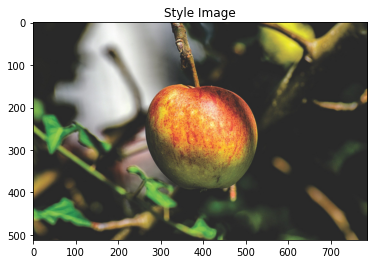

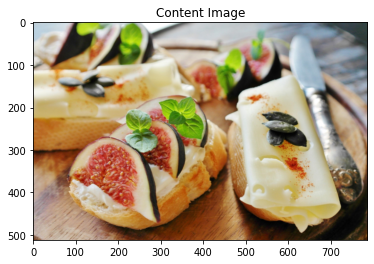

In [4]:
unloader = transforms.ToPILImage()
plt.ion()

def imshow(tensor, title=None, axis=True):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    if not axis: plt.axis("off")
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')


# The content loss function

In [5]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

# The style loss function

In [6]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [7]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Loading the neural network

In [8]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

In [9]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

In [10]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/style losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f'conv_{i}'
        elif isinstance(layer, nn.ReLU):
            name = f'relu_{i}'
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f'pool_{i}'
        elif isinstance(layer, nn.BatchNorm2d):
            name = f'bn_{i}'
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

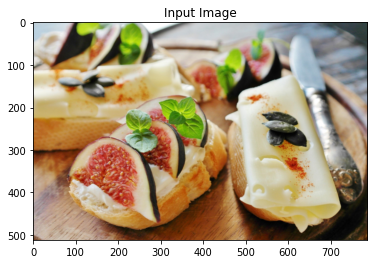

In [11]:
input_img = content_img.clone()
plt.figure()
imshow(input_img, title='Input Image')

# Gradient Descent

In [12]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# Training loop function

In [13]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):

    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    style_losses_l=[]
    content_losses_l=[]
    outputs_images_l=[]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            style_losses_l.append(style_score.item())
            content_losses_l.append(content_score.item())
            if run[0] % 50 == 0:
                print(f"run {run}:")
                print(f'Style Loss : {style_score.item():4f} || Content Loss: {content_score.item():4f}\n')
                plt.figure()
                outputs_images_l.append(input_img)
                imshow(input_img, title=f'Output Image After {run[0]} Iterations')
                plt.ioff()
                plt.show()
                print()

            

            return style_score + content_score

        optimizer.step(closure)


    input_img.data.clamp_(0, 1)

    return input_img, style_losses_l, content_losses_l, outputs_images_l

# Model Training

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Optimizing..
run [50]:
Style Loss : 36.018375 || Content Loss: 7.025199



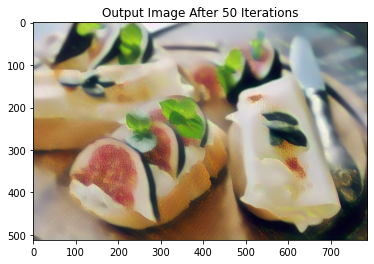


run [100]:
Style Loss : 24.506031 || Content Loss: 5.701026



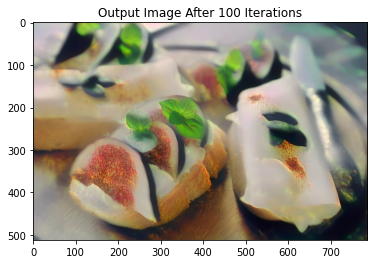


run [150]:
Style Loss : 15.089304 || Content Loss: 5.782650



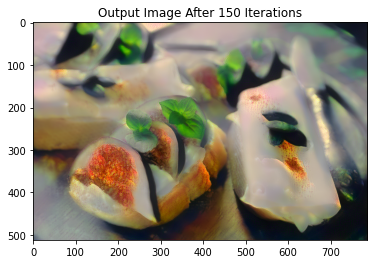


run [200]:
Style Loss : 9.525970 || Content Loss: 5.634298



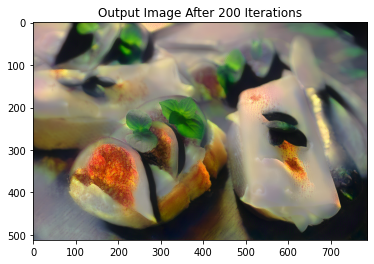


run [250]:
Style Loss : 5.858910 || Content Loss: 5.485236



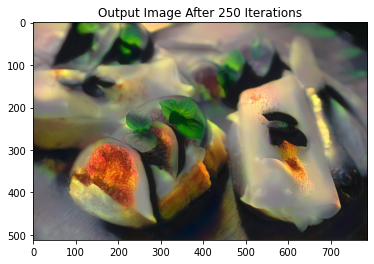


run [300]:
Style Loss : 3.639963 || Content Loss: 5.307499



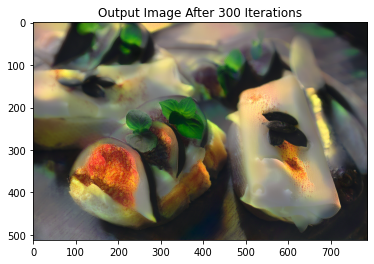


run [350]:
Style Loss : 2.424456 || Content Loss: 5.083795



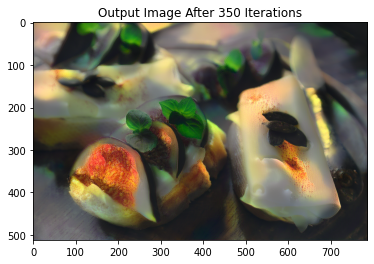


run [400]:
Style Loss : 1.804267 || Content Loss: 4.856253



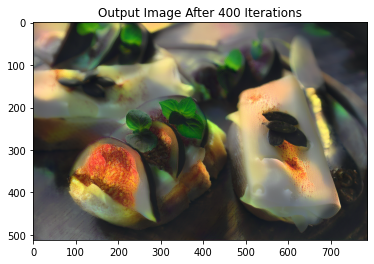


run [450]:
Style Loss : 1.458622 || Content Loss: 4.684679



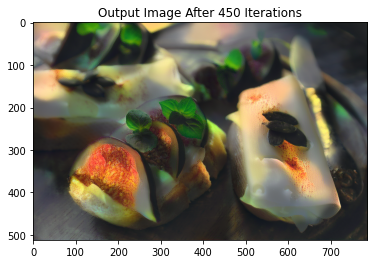


run [500]:
Style Loss : 1.242807 || Content Loss: 4.545880



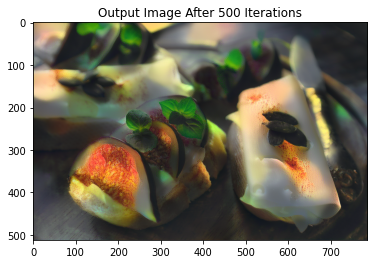

In [14]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std, content_img, style_img, input_img, num_steps=500)


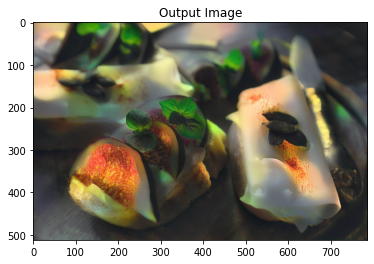

In [15]:
plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()

# Model Evaluation

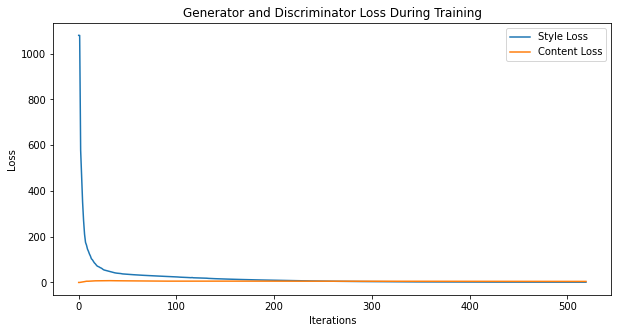

In [16]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(style_losses_l,label="Style Loss")
plt.plot(content_losses_l,label="Content Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(), 
plt.show()

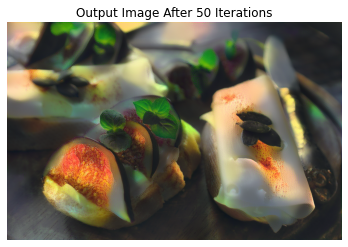

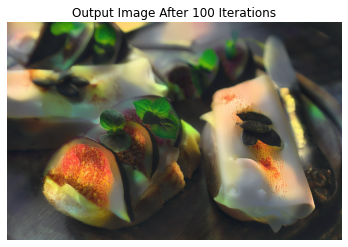

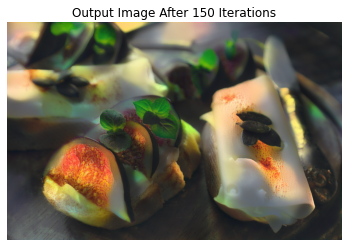

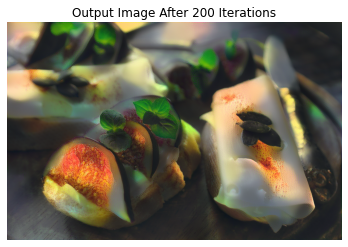

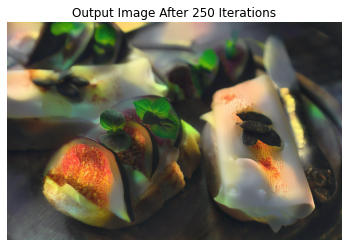

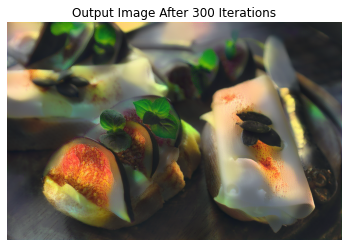

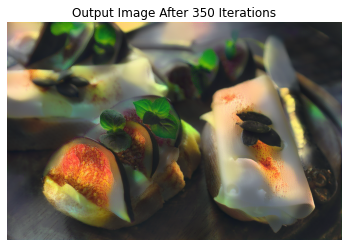

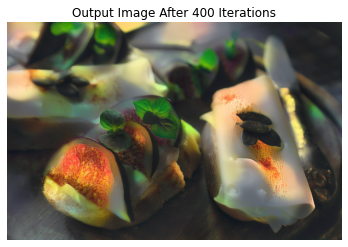

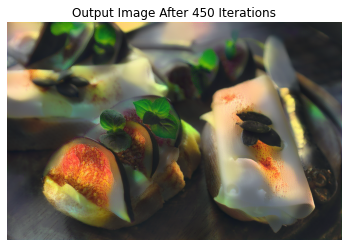

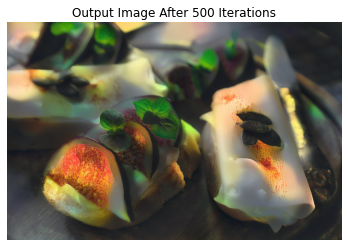

In [20]:
cpt=50
for i in outputs_images_l:
  plt.figure()
  imshow(output, title=f'Output Image After {cpt} Iterations', axis=False)
  plt.ioff()
  plt.show()
  cpt+=50